# 01: Review and Explore Data for Load forecasting/Generator Scheduling Experiment

Date: 2022-07-14

In [172]:
import os
#os.chdir('..')
import pandas as pd
# for timezone conversion
import datetime as dt
import pytz
# for holidays
import holidays
# for DST
import time
import numpy as np

## Basic Data Cleaning

In [143]:
# read in dataset
testread = pd.read_csv('data/pjm_load_data_2008-11.txt', sep = " ", header=None, 
                       usecols = [1, 2, 3], names = ["time", "load", "temp"])

In [136]:
testread.head()

,time,load,temp
0,1.199167e+09,1.477345,35.385
1,1.199171e+09,1.414483,37.300
2,1.199174e+09,1.363922,39.000
3,1.199178e+09,1.335267,39.050
4,1.199182e+09,1.317172,39.765


In [149]:
# clean time
#testread["time"] = pd.to_datetime(testread['time'], unit = 's', utc = True)
testread["time"] = [pd.Timestamp(nums, unit = 's', tz = "utc") for nums in testread["time"]]
# convert timezone from UTC to NY
tz = pytz.timezone('America/New_York')
testread["time_ny"] = [ts.astimezone(tz) for ts in testread["time"]]

In [150]:
testread.head()

,time,load,temp,time_ny
0,2008-01-01 06:00:00+00:00,1.477345,35.385,2008-01-01 01:00:00-05:00
1,2008-01-01 07:00:00+00:00,1.414483,37.300,2008-01-01 02:00:00-05:00
2,2008-01-01 08:00:00+00:00,1.363922,39.000,2008-01-01 03:00:00-05:00
3,2008-01-01 09:00:00+00:00,1.335267,39.050,2008-01-01 04:00:00-05:00
4,2008-01-01 10:00:00+00:00,1.317172,39.765,2008-01-01 05:00:00-05:00


In [184]:
df_cleaned = testread[["time_ny", "load", "temp"]]

## Plots to View Data

### Temperature

<AxesSubplot:title={'center':'All data'}, xlabel='time_ny'>

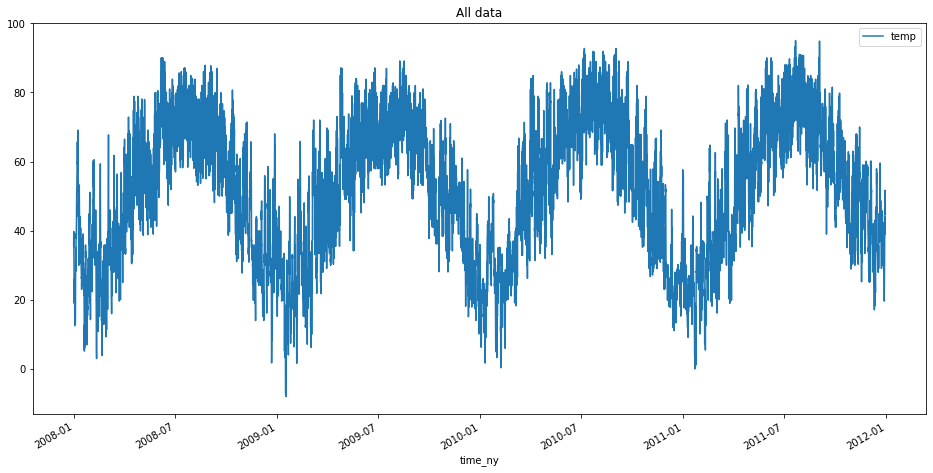

In [155]:
df_cleaned.plot(x = "time_ny", y = "temp", title = 'All data', figsize = (16, 8))

<AxesSubplot:title={'center':'Week of Jan 1st Temperature'}, xlabel='time_ny'>

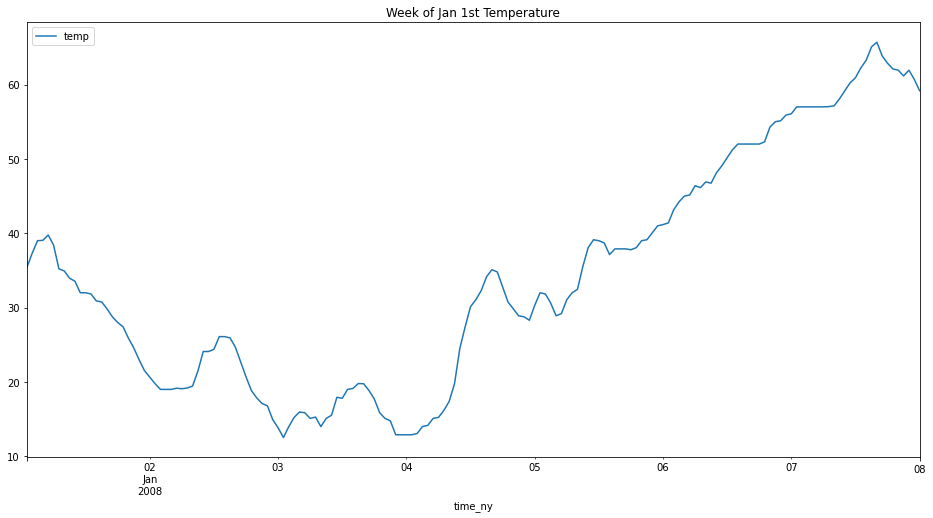

In [156]:
#plot one winter week
first_week = df_cleaned[:(24*7)]
first_week.plot(x = "time_ny", y = "temp", title = "Week of Jan 1st Temperature", figsize = (16, 8))

<AxesSubplot:title={'center':'Week of June 1st Temperature'}, xlabel='time_ny'>

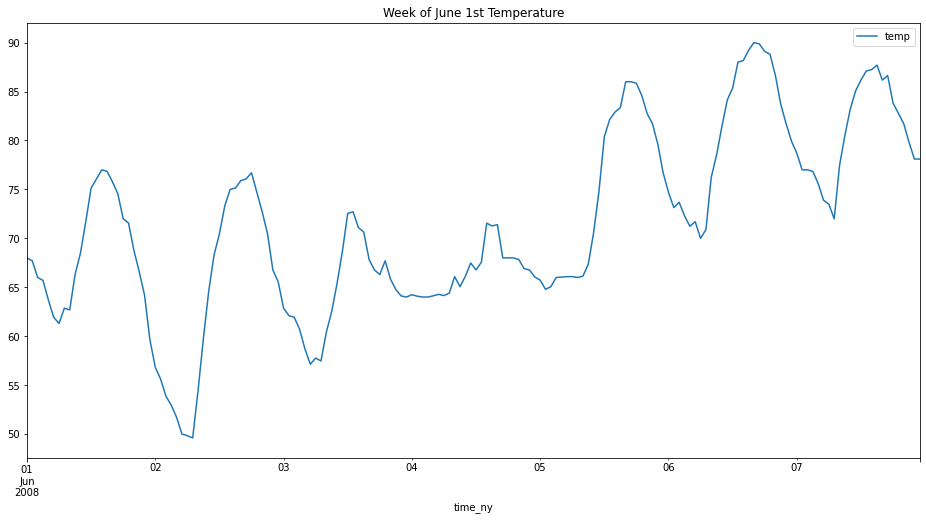

In [157]:
# plot one summer week
summer_week = df_cleaned[df_cleaned.time_ny.dt.month == 6][:(24*7)]
summer_week.plot(x = "time_ny", y = "temp", title = "Week of June 1st Temperature", figsize = (16, 8))

Just do a sanity check that time conversion seemed to be working correctly. 

### Load

<AxesSubplot:title={'center':'All data - load '}, xlabel='time_ny'>

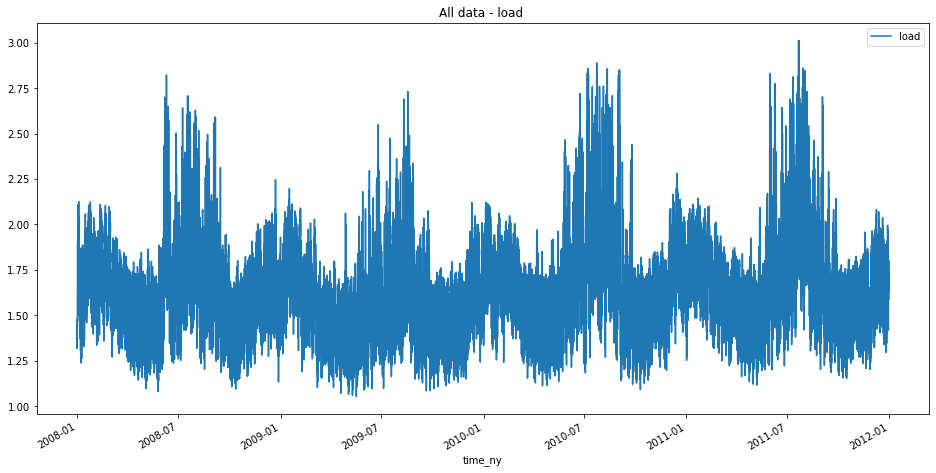

In [51]:
df_cleaned.plot(x = "time_ny", y = "load", title = 'All data - load ', figsize = (16, 8))

<AxesSubplot:title={'center':'Week of Jan 1st Load'}, xlabel='time_ny'>

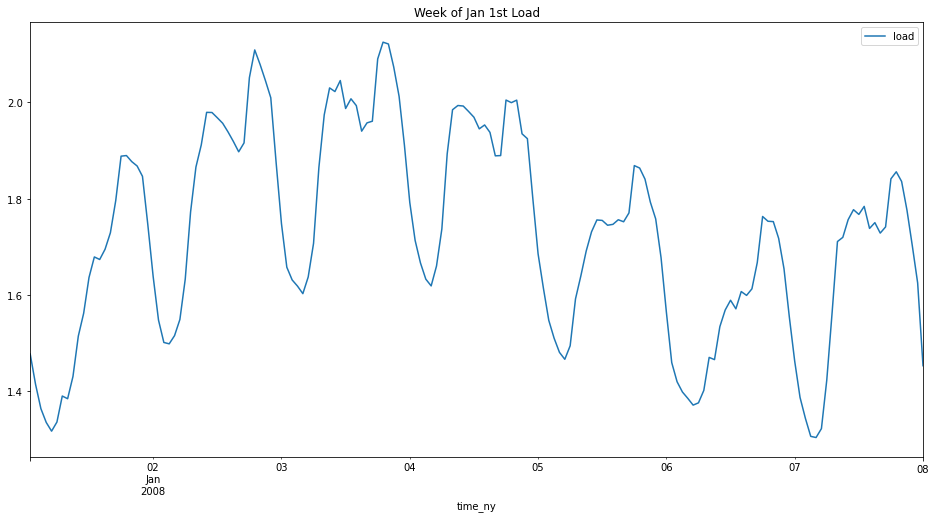

In [49]:
first_week.plot(x = "time_ny", y = "load", title = "Week of Jan 1st Load", figsize = (16, 8))

<AxesSubplot:title={'center':'Week of June 1st Load'}, xlabel='time_ny'>

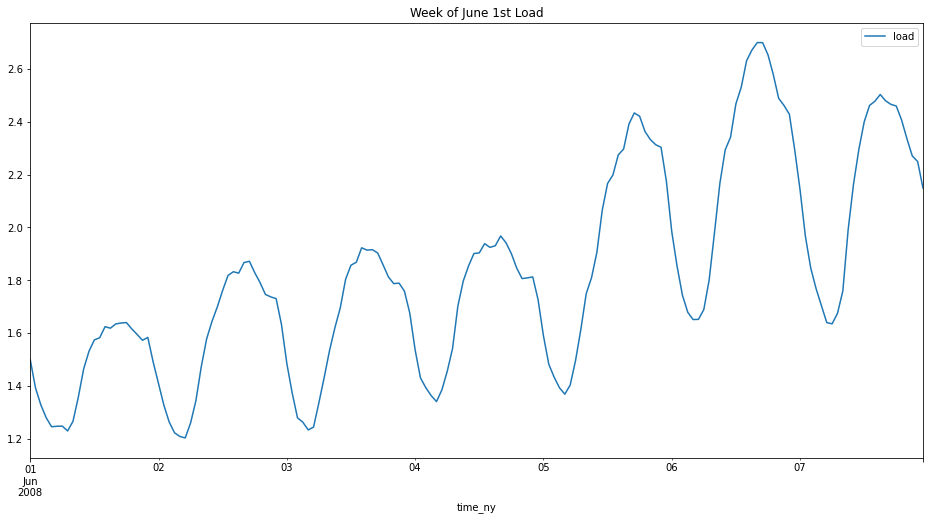

In [50]:
summer_week.plot(x = "time_ny", y = "load", title = "Week of June 1st Load", figsize = (16, 8))

## Data Summary

In [54]:
df_cleaned.describe()

,load,temp
count,35039.000000,35039.000000
mean,1.670218,51.828336
std,0.294389,19.276114
min,1.052455,-8.000000
25%,1.458749,35.865000
50%,1.649311,53.400000
75%,1.827743,67.700000
max,3.011643,95.000000


In [56]:
# look for missing data 
df_cleaned.isnull().sum()

time_ny    0
load       0
temp       0
dtype: int64

No missing data! 

## Prepare Data for Model

Need these variables: 
- Past Load - past 24 hours
- Past Temp - past 24 hours
- (Past Temp)^2 
- Future Temp
- (Future Temp)^2
- (Future Temp)^3
- I(Weekday)
- I(Holiday)
- I(DST) - indicator for daylight savings time
- sin(2$\pi$ x DOY) - DOY: day of year (number between 1 and 365)
- cos(2$\pi$ x DOY)

One set of data includes data for the day (24 hours). 

In [185]:
df_cleaned["date"] = df_cleaned.time_ny.dt.date
df_cleaned["hour"] = df_cleaned.time_ny.dt.hour

In [186]:
df_cleaned.head()

,time_ny,load,temp,date,hour,day
0,2008-01-01 01:00:00-05:00,1.477345,35.385,2008-01-01,1,2008-01-01
1,2008-01-01 02:00:00-05:00,1.414483,37.300,2008-01-01,2,2008-01-01
2,2008-01-01 03:00:00-05:00,1.363922,39.000,2008-01-01,3,2008-01-01
3,2008-01-01 04:00:00-05:00,1.335267,39.050,2008-01-01,4,2008-01-01
4,2008-01-01 05:00:00-05:00,1.317172,39.765,2008-01-01,5,2008-01-01


In [202]:
# check for duplicates - this seems to be when daylight savings transfer happens 
duplicates = (df_cleaned.groupby(['day', 'hour']).count() > 1)
duplicates[duplicates.load]

,,time_ny,load,temp,date
day,hour,,,,
2008-03-09,3,True,True,True,True
2009-03-08,3,True,True,True,True
2010-03-14,3,True,True,True,True
2011-03-13,3,True,True,True,True


In [257]:
# reformat data to be by day
df_day = pd.pivot_table(df_cleaned, index = 'date', columns = 'hour', values = ['temp', 'load'], aggfunc = 'mean')
df_day.columns = [f'{i}_{j}' for i, j in df_day.columns]
df_day.reset_index(inplace = True)
df_day["date"] = [pd.Timestamp(tm, tz = tz) for tm in df_day["date"]]

In [258]:
df_day.head()

,date,load_0,load_1,load_2,load_3,load_4,load_5,load_6,load_7,load_8,...,temp_14,temp_15,temp_16,temp_17,temp_18,temp_19,temp_20,temp_21,temp_22,temp_23
0,2008-01-01 00:00:00-05:00,NaN,1.477345,1.414483,1.363922,1.335267,1.317172,1.336110,1.390134,1.384562,...,30.900,30.765000,29.835,28.765,28.0000,27.427273,25.898276,24.584615,23.000,21.529412
1,2008-01-02 00:00:00-05:00,1.638353,1.547900,1.501405,1.498565,1.515585,1.549149,1.632906,1.772550,1.865784,...,26.100,25.935000,24.700,22.700,20.7000,18.850000,17.865000,17.100000,16.800,14.935000
2,2008-01-03 00:00:00-05:00,1.748204,1.657729,1.631283,1.618455,1.602828,1.637414,1.707257,1.864876,1.974241,...,19.135,19.790244,19.765,18.850,17.7000,15.865000,15.100000,14.770000,12.900,12.900000
3,2008-01-04 00:00:00-05:00,1.792341,1.713451,1.666581,1.632931,1.618902,1.660159,1.737172,1.893254,1.984880,...,32.300,34.165000,35.100,34.800,32.7700,30.765000,29.835000,28.900000,28.765,28.300000
4,2008-01-05 00:00:00-05:00,1.685581,1.613860,1.547408,1.510216,1.480833,1.466431,1.494527,1.591901,1.639697,...,37.135,37.900000,37.900,37.900,37.7875,38.065000,39.000000,39.135000,40.065,41.000000


In [250]:
# I (weekday) 
# 0 is Monday
df_day["weekday"] = df_day["date"].dt.weekday
df_day["weekday"] = df_day["weekday"].apply(lambda x: 1 if x in range(5) else 0)

In [251]:
# I (holiday) 
for holiday in holidays.USA(years=range(2008, 2010)).items():
    print(holiday)

(datetime.date(2008, 1, 1), "New Year's Day")
(datetime.date(2008, 1, 21), 'Martin Luther King Jr. Day')
(datetime.date(2008, 2, 18), "Washington's Birthday")
(datetime.date(2008, 5, 26), 'Memorial Day')
(datetime.date(2008, 7, 4), 'Independence Day')
(datetime.date(2008, 9, 1), 'Labor Day')
(datetime.date(2008, 10, 13), 'Columbus Day')
(datetime.date(2008, 11, 11), 'Veterans Day')
(datetime.date(2008, 11, 27), 'Thanksgiving')
(datetime.date(2008, 12, 25), 'Christmas Day')
(datetime.date(2009, 1, 1), "New Year's Day")
(datetime.date(2009, 1, 19), 'Martin Luther King Jr. Day')
(datetime.date(2009, 2, 16), "Washington's Birthday")
(datetime.date(2009, 5, 25), 'Memorial Day')
(datetime.date(2009, 7, 4), 'Independence Day')
(datetime.date(2009, 7, 3), 'Independence Day (Observed)')
(datetime.date(2009, 9, 7), 'Labor Day')
(datetime.date(2009, 10, 12), 'Columbus Day')
(datetime.date(2009, 11, 11), 'Veterans Day')
(datetime.date(2009, 11, 26), 'Thanksgiving')
(datetime.date(2009, 12, 25), 'C

In [253]:
holiday_dict = holidays.USA(years=range(2008, 2014)).items()
holiday_dates = [item[0] for item in holiday_dict]
df_day["holiday"] = df_day["date"].apply(lambda x: 1 if x.date() in holiday_dates else 0)

<AxesSubplot:xlabel='date'>

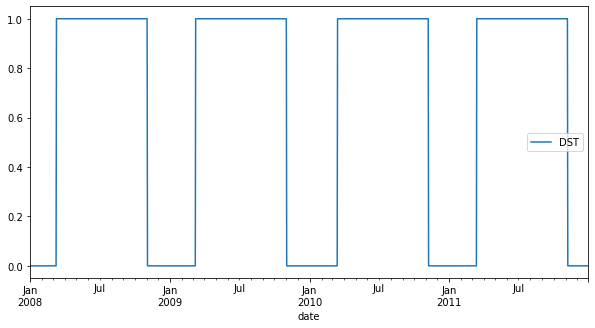

In [259]:
# DST 
# df_cleaned["time_ny"][0].timetuple().tm_isdst
df_day["DST"] = [tm.timetuple().tm_isdst for tm in df_day["date"]]
# sanity check 
df_day.plot(x = "date", y = "DST", figsize = (10, 5))

In [262]:
# sin and cos of 2*pi*DOY
df_day["DOY"] = [tm.timetuple().tm_yday for tm in df_day["date"]]
df_day["sin"] = np.sin(2*np.pi*df_day["DOY"]/365)
df_day["cos"] = np.cos(2*np.pi*df_day["DOY"]/365)

<AxesSubplot:xlabel='date'>

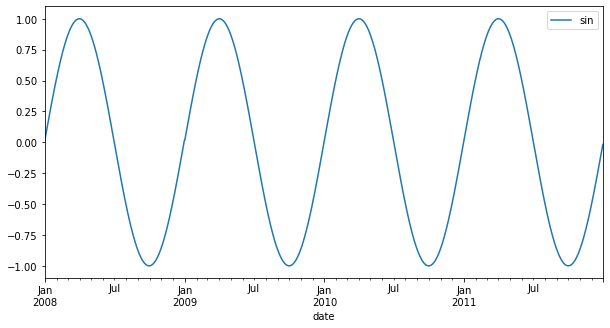

In [263]:
# sanity check plots
df_day.plot(x = "date", y = "sin", figsize = (10, 5))

<AxesSubplot:xlabel='date'>

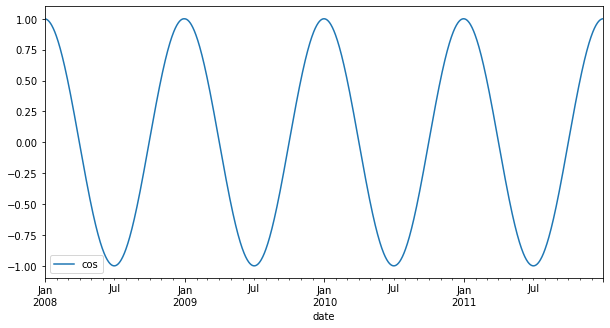

In [264]:
# sanity check plots
df_day.plot(x = "date", y = "cos", figsize = (10, 5))

In [265]:
df_day.head()

,date,load_0,load_1,load_2,load_3,load_4,load_5,load_6,load_7,load_8,...,temp_18,temp_19,temp_20,temp_21,temp_22,temp_23,DST,DOY,sin,cos
0,2008-01-01 00:00:00-05:00,NaN,1.477345,1.414483,1.363922,1.335267,1.317172,1.336110,1.390134,1.384562,...,28.0000,27.427273,25.898276,24.584615,23.000,21.529412,0,1,0.017213,0.999852
1,2008-01-02 00:00:00-05:00,1.638353,1.547900,1.501405,1.498565,1.515585,1.549149,1.632906,1.772550,1.865784,...,20.7000,18.850000,17.865000,17.100000,16.800,14.935000,0,2,0.034422,0.999407
2,2008-01-03 00:00:00-05:00,1.748204,1.657729,1.631283,1.618455,1.602828,1.637414,1.707257,1.864876,1.974241,...,17.7000,15.865000,15.100000,14.770000,12.900,12.900000,0,3,0.051620,0.998667
3,2008-01-04 00:00:00-05:00,1.792341,1.713451,1.666581,1.632931,1.618902,1.660159,1.737172,1.893254,1.984880,...,32.7700,30.765000,29.835000,28.900000,28.765,28.300000,0,4,0.068802,0.997630
4,2008-01-05 00:00:00-05:00,1.685581,1.613860,1.547408,1.510216,1.480833,1.466431,1.494527,1.591901,1.639697,...,37.7875,38.065000,39.000000,39.135000,40.065,41.000000,0,5,0.085965,0.996298
